In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

In [3]:
sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

0 중심을 가진 정규분포에서 100개의 점을 샘플링하자. <br>
목표는 평균 $\mu$(표준편차는 1임을 알고 있다고 가정)의 사후분포를 추정하는 것.  

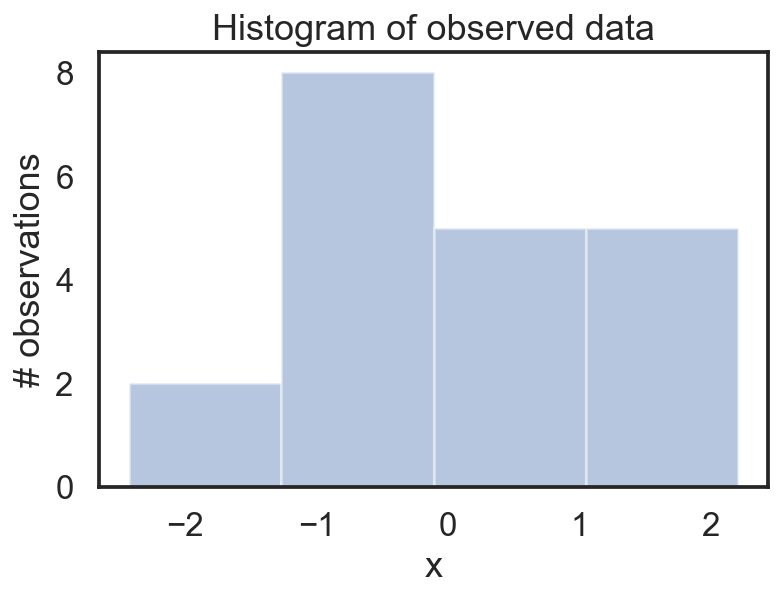

In [4]:
data = np.random.randn(20)
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

이런 경우 우리는 베이즈 추정을 통해 추정할 수 있다. <br>
분산 모수 알고 있다고 가정한 정규분포의 경우, <br>
$\mu$의 prior 분포로 정규분포를 가정하고, posterior 분포를 구하면 정규분포가 나오게 된다. <br>

$conjugate$임을 통해 쉽게 구할 수 있었다. 

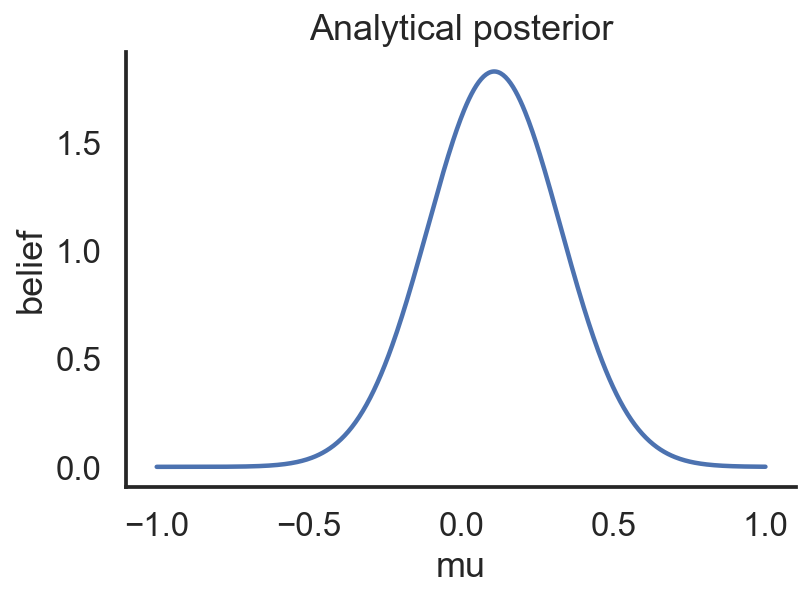

In [5]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

위는 우리가 알고자하는, 사전 확률 정보를 고려하고, 데이터를 보고난 후의 $\mu$의 값들의 확률의 양적 수치를 보여준다. 

### 그런데 문제는
그러나, 사전확률이 conjugate 가 아니고, 손으로 사후 확률을 구할 수 없는 경우이다. 

## Explaining MCMC sampling with code

샘플링 로직을 보자. 맨처음에는, (랜덤으로 선택할 수 있는) 시작 파라메터 지점을 임의로 지정한다.

In [11]:
?norm

In [8]:
mu_current = 1.

그 후, 그 지점을 어느곳으로 옮길지 알아야한다. 이것이 마르코프가 하는 일이다. 독자들은 어떻게 옮길 지점을 알지에 대해서 잘 알수도, 모를 수도 있다.

Metropolis sampler는 매우 멍청하고, 단지 현재 mu 값(즉, mu_current)이 중심이고 특정 표준편차(proposal_width)를 가진 정규 분포에서 표본을 추출한다(모델에 대해서 가정한 정규분포와는 관계없음). proposal_width는 얼마나 멀리 새자리로 옮길지를 결정할 것이다.

In [7]:
proposal = norm(mu_current, proposal_width).rvs()

NameError: name 'proposal_width' is not defined

다음에는, 옮긴 장소가 좋은 곳인지 평가한다. 제안된 mu를 가진 정규 분포가 예전 mu보다 데이터를 좀 더 잘 설명한다면, 당연히 그곳으로 가고 싶을 것이다. “데이터를 좀 더 잘 설명"한다는 것은 무슨 의미일까? 제안된 파라메터 값(제안된 mu와 고정된 sigma)을 가진 우도가 주어졌을때 (정규분포) 데이터의 확률을 계산함으로써 적합함을 수치화한다.

scipy.stats.normal(mu, sigma).pdf(data)을 사용해서 각 데이터 포인트에 대한 확률을 계산하고 각 확률을 곱함으로써 이를 구할 수 있다. 즉 우도를 계산한다(보통 log 확률을 쓰지만 여기서는 생략)

In [ ]:
likelihood_current = norm(mu_current, 1).pdf(data).prod()
likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()

# Compute prior probability of current and proposed mu        
# mu_prior_mu와 mu_prior_sd는 우리의 사전지식. 알고 있다고 가정한다.

prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)

# Nominator of Bayes formula
p_current = likelihood_current * prior_current
p_proposal = likelihood_proposal * prior_proposal

지금까지, 본질적으로 랜덤한 방향으로 움직임을 제안하고 mu_proposal가 mu_current보다 높은 우도를 가지는 경우에만 그 움직임를 받아드리는 언덕 오르기 알고리즘을 시행했다. 결국, 더이상 이동할 수 없는 mu=0 (또는 0에 가까운) 를 얻을 것이다.

그러나, 사후 확률을 얻고 가끔은 다른 방향으로의 움직임을 승인해야 한다. 가장 중요한 비결은 두 확률을 나누는 것이다.

In [ ]:
p_accept = p_proposal / p_current

승인 확률을 얻었다. p_proposal가 크면, 저 확률은 >1 일것이며, 승인 된다. 그러나, p_current가 크면, 예를 들어 두배 크면, 움직일 확률은 50%가 될 것이다.



rand는 0과 1사이 값을 리턴한다. <br>
이렇게 되면, p_accept가 1보다 클때는 무조건 accept하고, <br>
그게 아니여도 accept의 가능성이 생긴다.

In [ ]:
accept = np.random.rand() < p_accept

if accept:
    # Update position
    cur_pos = proposal

이 간단한 프로시져가 사후확률에서 표본을 얻을수 있게 해준다

## Why does this make sense?

한 걸음 뒤로 물러나서, 위의 승인 비율이 이 것이 동작하고, 적분을 피할수 있는 이유임을 주목하자. 정규화된 사후확률에 대한 승인률을 구하고 정규화되지 않은 사후확률의 승인률과 같음을 보임으로써 이를 보일 수 있다. $\mu_0$를 현재 지점이고 $\mu_1$를 제안지점이라고 하자. 

![2_245.png](./materials/2_245.png)


말로 하면, 제안된 파라메터 setting의 사후확률을 현재 파라메터 setting의 사후확률로 나누면, 계산할 수 없는 양 s는 소거된다. 그래서, 한 지점에서 full posterior를 다른 지점에서의 full posterior와 실제로 나눈 것과 같은 것임을 직감할 수 있다.

저 방법으로, 상대적으로 높은 사후확률을 가진 지점을 좀 더 자주 방문 할 수 있다.

## Putting it all together

In [19]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()

        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)

        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal

        # Accept proposal?
        p_accept = p_proposal / p_current

        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept

        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)

        if accept:
            # Update position
            mu_current = mu_proposal

        posterior.append(mu_current)

    return posterior

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'

    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))

    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))

    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))

    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

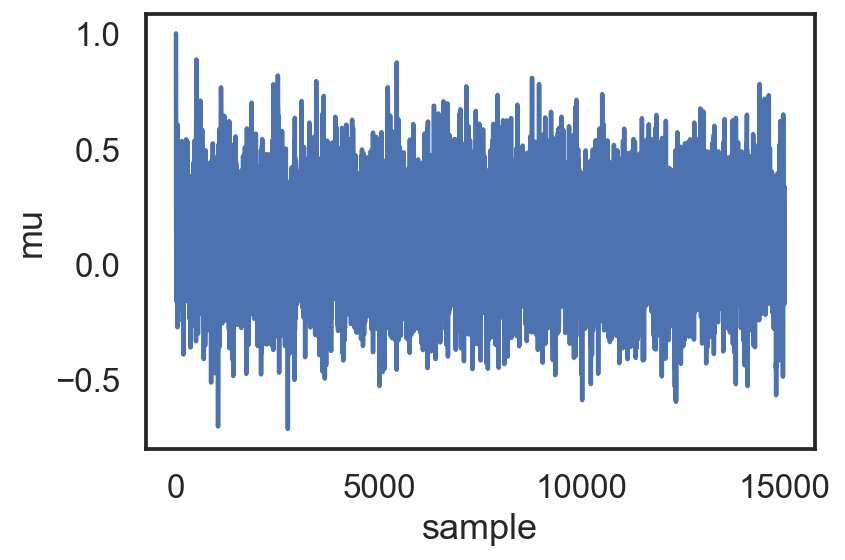

In [20]:
posterior = sampler(data, samples=15000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');


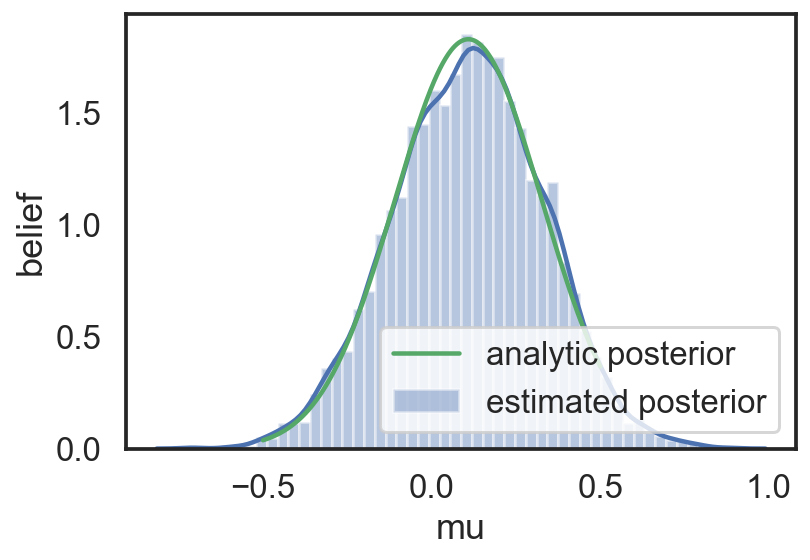

In [21]:
ax = plt.subplot()

sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();


### Proposal Width

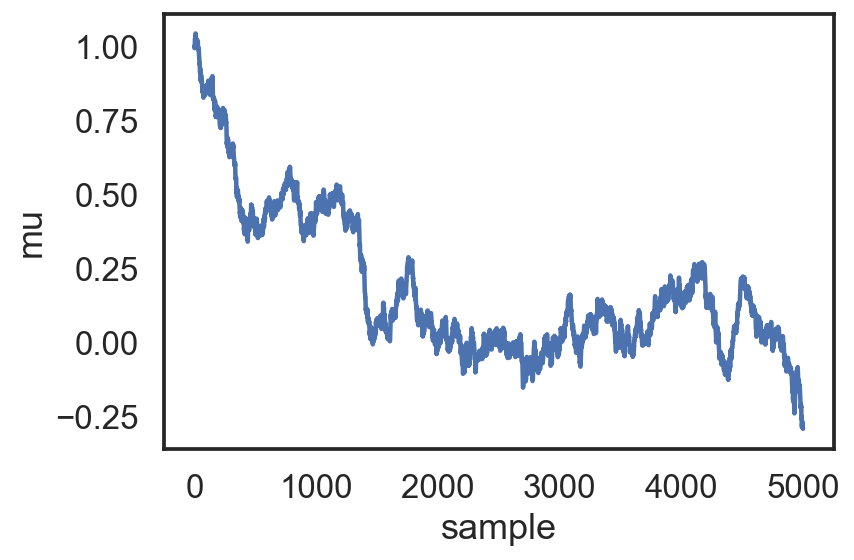

In [22]:
posterior_small = sampler(data, samples=5000, mu_init=1., proposal_width=.01)
fig, ax = plt.subplots()
ax.plot(posterior_small);
_ = ax.set(xlabel='sample', ylabel='mu');

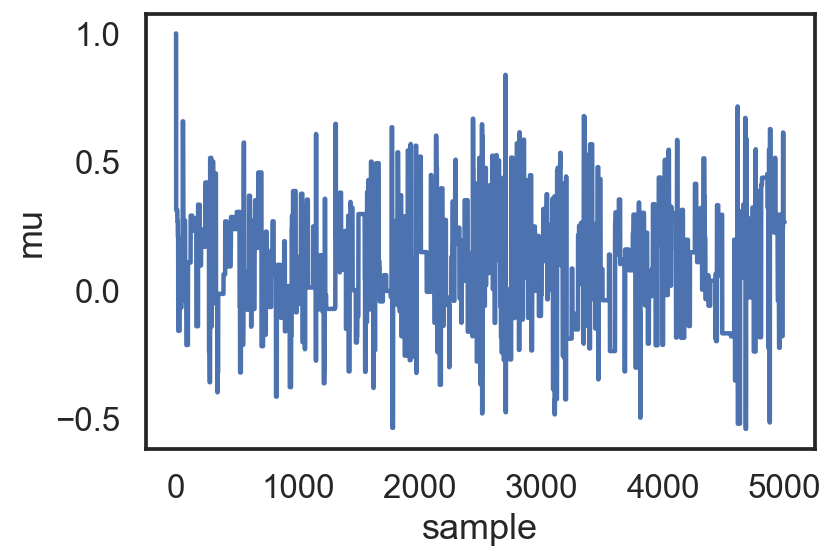

In [23]:
posterior_large = sampler(data, samples=5000, mu_init=1., proposal_width=3.)
fig, ax = plt.subplots()
ax.plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu');
_ = ax.set(xlabel='sample', ylabel='mu');

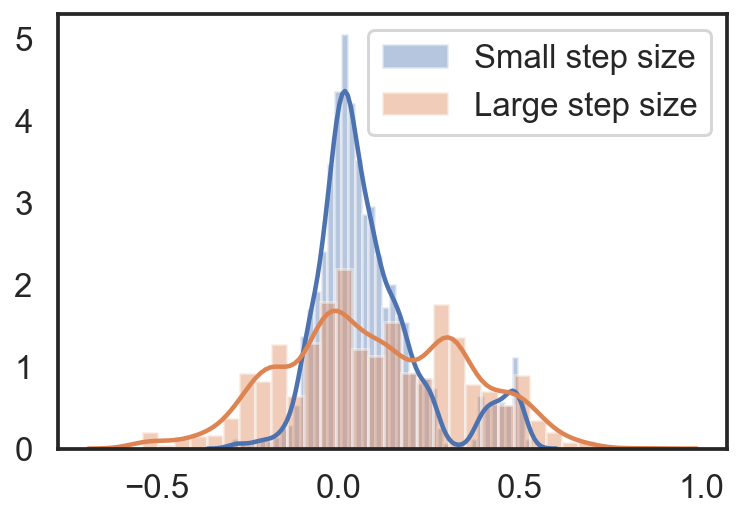

In [24]:
sns.distplot(posterior_small[1000:], label='Small step size')
sns.distplot(posterior_large[1000:], label='Large step size');
_ = plt.legend();
